In [2]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers
import matplotlib.pyplot as plt
from keras import optimizers
import os
#print(os.listdir("../input/encrypt-bug"))

In [ ]:
coverage = pd.read_csv('../input/sort-bugXJY/sort_bug1.csv')
coverage # check coverage information

In [3]:
def read_coverage(inputstream):
    coverage = pd.read_csv(inputstream)
    rows, columns = coverage.shape
    m = coverage[coverage.columns[1:-1]]
    m = np.matrix(m)
    result = coverage[coverage.columns[-1]]
    result = np.array(result)
    return m, result, columns-2

In [4]:
#######################################
#           Procedure I               #
#######################################

def get_train_data(): # simulate, example in BPNN paper
    m = np.matrix([
        [1,1,1,1,0,1,0,0,1],
        [1,0,0,0,1,1,1,1,0],
        [0,0,0,0,0,1,1,0,0],
        [1,1,0,0,1,0,1,1,1],
        [1,1,1,0,1,1,1,1,1],
        [0,0,1,0,0,1,1,1,0],
        [1,1,1,1,0,1,0,1,1]
    ]).astype(int)
    result = np.array([0,0,0,0,0,1,1])
    return m, result

def create_virtual_test(n):
    c = np.diag(np.ones(n-1), 1) 
    return c

def build_model(n_statement):
    model = Sequential()
    # input layer is m.size
    # hidden layer one
    initiallizer = initializers.RandomUniform(minval=-0.01*n_statement, maxval=0.01*n_statement, seed=None)
    model.add(Dense(3, input_dim=n_statement, activation='relu', 
                    kernel_initializer= initiallizer,
                    bias_initializer='zeros',
                    kernel_regularizer=regularizers.l2(0.01)))
    # hidden layer 
#     model.add(Dense(3, activation='sigmoid', 
#                     kernel_regularizer=regularizers.l2(0.01)
#                    ))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model    


def train_model(m,result,n_statement,epochs, lr):
    model = build_model(n_statement)
    sgd = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    #rmsprop = optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer= sgd, metrics=['accuracy'])
    history = model.fit(m, result, epochs=epochs) #  batch_size=10

    # summarize history for accuracy
#     plt.plot(history.history['acc'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return model

def selectionSort(rlist):
    index = [x for x in range(len(rlist))]
    rank = [x for x in range(len(rlist))]
    for i in range(len(index)):
        idx = i
        j = i+1
        while j > i and j < len(index):
            if (rlist[idx] < rlist[j]):
                idx = j
            j+=1
        rlist[i],rlist[idx] = swap(rlist[i],rlist[idx])
        index[i], index[idx] = index[idx], index[i]
        i+=1
    return rank, index

def swap(a,b): # just for np.array
    temp = a.copy()
    a = b
    b = temp
    return a, b

#######################################
#           Procedure II              #
#######################################

def find_si(m, result, n_statement):
    si = np.zeros(n_statement)
    for i in range(result.size):
        if result[i] == 0:  
            continue
        for j in range(n_statement):
            if m[i,j] == 0: 
                si[j]-=10000 # assume n_statement < 10000
            else:
                si[j]+=1
    for j in range(n_statement):
        if (si[j] <= 0): si[j] = 0
        else: si[j] = 1
    return si

def find_sm(m, result):
    t = np.zeros(result.size)
    minidx = 0
    minsum = 10000 # assume n_statement < 10000
    for i in range(result.size):
        if result[i] == 0:  
            continue
        t[i] = np.sum(m[i])
        if t[i] < minsum:
            minsum = t[i]
            minidx = i
    sm = m[minidx]
    return sm

def procedure1(r_virtual):
    r_virtual1 = r_virtual.copy()
    rank, index= selectionSort(r_virtual1)
    print("Procedure I")
    for i in range(len(rank)):
        print("Statement {:>2}: {:>4}".format(index[i]+1,rank[i]+1))
        
def procedure2(r_virtual): # improvement suggested in paper
    r_virtual2 = r_virtual.copy()
    print("Procedure II (improvement)")
    # Procedure II
    si = find_si(m,result,n_statement)
    sm = find_sm(m,result)
    for i in range(len(si)):
        if(si[i] != 0 and sm[0,i] != 0):
            r_virtual2[i] +=2.0
            print("Statement {:>2} should be checked firstly (Si)".format(i+1))
        if(si[i] == 0 and sm[0,i] == 1):
            r_virtual2[i] +=1.0
            print("Statement {:>2} should be checked secondly (Sm)".format(i+1))
    rank, index= selectionSort(r_virtual2)
    print("Final Result")
    for i in range(len(rank)):
        print("Statement {:>2}: {:>4}".format(index[i]+1,rank[i]+1))
    

Epoch 1/3000
300/300 [==============================] - 0s 2ms/step - loss: 2.5277 - acc: 0.7100
Epoch 2/3000
300/300 [==============================] - 0s 46us/step - loss: 2.2278 - acc: 0.7567
Epoch 3/3000
300/300 [==============================] - 0s 53us/step - loss: 2.0124 - acc: 0.7767
Epoch 4/3000
300/300 [==============================] - 0s 68us/step - loss: 1.7914 - acc: 0.8067
Epoch 5/3000
300/300 [==============================] - 0s 53us/step - loss: 1.5616 - acc: 0.8533
Epoch 6/3000
300/300 [==============================] - 0s 55us/step - loss: 1.3521 - acc: 0.9100
Epoch 7/3000
300/300 [==============================] - 0s 65us/step - loss: 1.1564 - acc: 0.9233
Epoch 8/3000
300/300 [==============================] - 0s 69us/step - loss: 0.9738 - acc: 0.9533
Epoch 9/3000
300/300 [==============================] - 0s 56us/step - loss: 0.8309 - acc: 0.9700
Epoch 10/3000
300/300 [==============================] - 0s 58us/step - loss: 0.7133 - acc: 0.9867
Epoch 11/3000
300/30

300/300 [==============================] - 0s 56us/step - loss: 0.0238 - acc: 1.0000
Epoch 84/3000
300/300 [==============================] - 0s 56us/step - loss: 0.0239 - acc: 1.0000
Epoch 85/3000
300/300 [==============================] - 0s 58us/step - loss: 0.0237 - acc: 1.0000
Epoch 86/3000
300/300 [==============================] - 0s 58us/step - loss: 0.0233 - acc: 1.0000
Epoch 87/3000
300/300 [==============================] - 0s 55us/step - loss: 0.0234 - acc: 1.0000
Epoch 88/3000
300/300 [==============================] - 0s 58us/step - loss: 0.0234 - acc: 1.0000
Epoch 89/3000
300/300 [==============================] - 0s 56us/step - loss: 0.0232 - acc: 1.0000
Epoch 90/3000
300/300 [==============================] - 0s 54us/step - loss: 0.0229 - acc: 1.0000
Epoch 91/3000
300/300 [==============================] - 0s 59us/step - loss: 0.0228 - acc: 1.0000
Epoch 92/3000
300/300 [==============================] - 0s 57us/step - loss: 0.0226 - acc: 1.0000
Epoch 93/3000
300/300 [=

300/300 [==============================] - 0s 38us/step - loss: 0.0170 - acc: 1.0000
Epoch 166/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0169 - acc: 1.0000
Epoch 167/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0169 - acc: 1.0000
Epoch 168/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0169 - acc: 1.0000
Epoch 169/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0167 - acc: 1.0000
Epoch 170/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0167 - acc: 1.0000
Epoch 171/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0167 - acc: 1.0000
Epoch 172/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0165 - acc: 1.0000
Epoch 173/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0166 - acc: 1.0000
Epoch 174/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0165 - acc: 1.0000
Epoch 175/3000


300/300 [==============================] - 0s 39us/step - loss: 0.0139 - acc: 1.0000
Epoch 248/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0139 - acc: 1.0000
Epoch 249/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0139 - acc: 1.0000
Epoch 250/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0141 - acc: 1.0000
Epoch 251/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0142 - acc: 1.0000
Epoch 252/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0138 - acc: 1.0000
Epoch 253/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0139 - acc: 1.0000
Epoch 254/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0141 - acc: 1.0000
Epoch 255/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0137 - acc: 1.0000
Epoch 256/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0138 - acc: 1.0000
Epoch 257/3000


300/300 [==============================] - 0s 46us/step - loss: 0.0122 - acc: 1.0000
Epoch 330/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0122 - acc: 1.0000
Epoch 331/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0124 - acc: 1.0000
Epoch 332/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0122 - acc: 1.0000
Epoch 333/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0121 - acc: 1.0000
Epoch 334/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0121 - acc: 1.0000
Epoch 335/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0121 - acc: 1.0000
Epoch 336/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0121 - acc: 1.0000
Epoch 337/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0121 - acc: 1.0000
Epoch 338/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0122 - acc: 1.0000
Epoch 339/3000


300/300 [==============================] - 0s 40us/step - loss: 0.0111 - acc: 1.0000
Epoch 412/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0112 - acc: 1.0000
Epoch 413/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0110 - acc: 1.0000
Epoch 414/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0110 - acc: 1.0000
Epoch 415/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0111 - acc: 1.0000
Epoch 416/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0109 - acc: 1.0000
Epoch 417/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0110 - acc: 1.0000
Epoch 418/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0109 - acc: 1.0000
Epoch 419/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0109 - acc: 1.0000
Epoch 420/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0110 - acc: 1.0000
Epoch 421/3000


300/300 [==============================] - 0s 40us/step - loss: 0.0101 - acc: 1.0000
Epoch 494/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0101 - acc: 1.0000
Epoch 495/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0101 - acc: 1.0000
Epoch 496/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0101 - acc: 1.0000
Epoch 497/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0101 - acc: 1.0000
Epoch 498/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0100 - acc: 1.0000
Epoch 499/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0100 - acc: 1.0000
Epoch 500/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0101 - acc: 1.0000
Epoch 501/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0101 - acc: 1.0000
Epoch 502/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0101 - acc: 1.0000
Epoch 503/3000


300/300 [==============================] - 0s 40us/step - loss: 0.0095 - acc: 1.0000
Epoch 576/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0095 - acc: 1.0000
Epoch 577/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0095 - acc: 1.0000
Epoch 578/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0095 - acc: 1.0000
Epoch 579/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0094 - acc: 1.0000
Epoch 580/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0094 - acc: 1.0000
Epoch 581/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0094 - acc: 1.0000
Epoch 582/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0094 - acc: 1.0000
Epoch 583/3000
300/300 [==============================] - 0s 51us/step - loss: 0.0094 - acc: 1.0000
Epoch 584/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0094 - acc: 1.0000
Epoch 585/3000


300/300 [==============================] - 0s 39us/step - loss: 0.0090 - acc: 1.0000
Epoch 658/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0089 - acc: 1.0000
Epoch 659/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0089 - acc: 1.0000
Epoch 660/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0089 - acc: 1.0000
Epoch 661/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0088 - acc: 1.0000
Epoch 662/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0088 - acc: 1.0000
Epoch 663/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0088 - acc: 1.0000
Epoch 664/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0089 - acc: 1.0000
Epoch 665/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0089 - acc: 1.0000
Epoch 666/3000
300/300 [==============================] - 0s 36us/step - loss: 0.0089 - acc: 1.0000
Epoch 667/3000


300/300 [==============================] - 0s 39us/step - loss: 0.0084 - acc: 1.0000
Epoch 740/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0084 - acc: 1.0000
Epoch 741/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0084 - acc: 1.0000
Epoch 742/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0084 - acc: 1.0000
Epoch 743/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0084 - acc: 1.0000
Epoch 744/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0084 - acc: 1.0000
Epoch 745/3000
300/300 [==============================] - 0s 53us/step - loss: 0.0084 - acc: 1.0000
Epoch 746/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0084 - acc: 1.0000
Epoch 747/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0085 - acc: 1.0000
Epoch 748/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0084 - acc: 1.0000
Epoch 749/3000


300/300 [==============================] - 0s 40us/step - loss: 0.0080 - acc: 1.0000
Epoch 822/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0081 - acc: 1.0000
Epoch 823/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0080 - acc: 1.0000
Epoch 824/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0080 - acc: 1.0000
Epoch 825/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0080 - acc: 1.0000
Epoch 826/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0080 - acc: 1.0000
Epoch 827/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0081 - acc: 1.0000
Epoch 828/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0080 - acc: 1.0000
Epoch 829/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0081 - acc: 1.0000
Epoch 830/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0080 - acc: 1.0000
Epoch 831/3000


300/300 [==============================] - 0s 48us/step - loss: 0.0077 - acc: 1.0000
Epoch 904/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0077 - acc: 1.0000
Epoch 905/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0077 - acc: 1.0000
Epoch 906/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0077 - acc: 1.0000
Epoch 907/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0077 - acc: 1.0000
Epoch 908/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0077 - acc: 1.0000
Epoch 909/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0077 - acc: 1.0000
Epoch 910/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0076 - acc: 1.0000
Epoch 911/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0077 - acc: 1.0000
Epoch 912/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0077 - acc: 1.0000
Epoch 913/3000


300/300 [==============================] - 0s 49us/step - loss: 0.0074 - acc: 1.0000
Epoch 986/3000
300/300 [==============================] - 0s 52us/step - loss: 0.0074 - acc: 1.0000
Epoch 987/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0074 - acc: 1.0000
Epoch 988/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0075 - acc: 1.0000
Epoch 989/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0074 - acc: 1.0000
Epoch 990/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0074 - acc: 1.0000
Epoch 991/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0075 - acc: 1.0000
Epoch 992/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0074 - acc: 1.0000
Epoch 993/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0073 - acc: 1.0000
Epoch 994/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0074 - acc: 1.0000
Epoch 995/3000


300/300 [==============================] - 0s 40us/step - loss: 0.0072 - acc: 1.0000
Epoch 1067/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0071 - acc: 1.0000
Epoch 1068/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0071 - acc: 1.0000
Epoch 1069/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0071 - acc: 1.0000
Epoch 1070/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0071 - acc: 1.0000
Epoch 1071/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0071 - acc: 1.0000
Epoch 1072/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0074 - acc: 1.0000
Epoch 1073/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0072 - acc: 1.0000
Epoch 1074/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0071 - acc: 1.0000
Epoch 1075/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0072 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0069 - acc: 1.0000
Epoch 1148/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0069 - acc: 1.0000
Epoch 1149/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0069 - acc: 1.0000
Epoch 1150/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0070 - acc: 1.0000
Epoch 1151/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0069 - acc: 1.0000
Epoch 1152/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0069 - acc: 1.0000
Epoch 1153/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0069 - acc: 1.0000
Epoch 1154/3000
300/300 [==============================] - 0s 60us/step - loss: 0.0069 - acc: 1.0000
Epoch 1155/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0069 - acc: 1.0000
Epoch 1156/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0069 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0068 - acc: 1.0000
Epoch 1229/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0067 - acc: 1.0000
Epoch 1230/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0067 - acc: 1.0000
Epoch 1231/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0067 - acc: 1.0000
Epoch 1232/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0067 - acc: 1.0000
Epoch 1233/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0067 - acc: 1.0000
Epoch 1234/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0067 - acc: 1.0000
Epoch 1235/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0067 - acc: 1.0000
Epoch 1236/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0067 - acc: 1.0000
Epoch 1237/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0068 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0065 - acc: 1.0000
Epoch 1310/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0065 - acc: 1.0000
Epoch 1311/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0065 - acc: 1.0000
Epoch 1312/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0066 - acc: 1.0000
Epoch 1313/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0065 - acc: 1.0000
Epoch 1314/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0065 - acc: 1.0000
Epoch 1315/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0066 - acc: 1.0000
Epoch 1316/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0065 - acc: 1.0000
Epoch 1317/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0065 - acc: 1.0000
Epoch 1318/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0065 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 45us/step - loss: 0.0063 - acc: 1.0000
Epoch 1391/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0064 - acc: 1.0000
Epoch 1392/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0064 - acc: 1.0000
Epoch 1393/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0063 - acc: 1.0000
Epoch 1394/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0063 - acc: 1.0000
Epoch 1395/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0063 - acc: 1.0000
Epoch 1396/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0063 - acc: 1.0000
Epoch 1397/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0063 - acc: 1.0000
Epoch 1398/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0064 - acc: 1.0000
Epoch 1399/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0063 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 44us/step - loss: 0.0062 - acc: 1.0000
Epoch 1472/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0063 - acc: 1.0000
Epoch 1473/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0062 - acc: 1.0000
Epoch 1474/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0062 - acc: 1.0000
Epoch 1475/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0062 - acc: 1.0000
Epoch 1476/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0062 - acc: 1.0000
Epoch 1477/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0062 - acc: 1.0000
Epoch 1478/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0062 - acc: 1.0000
Epoch 1479/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0062 - acc: 1.0000
Epoch 1480/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0063 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0061 - acc: 1.0000
Epoch 1553/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0061 - acc: 1.0000
Epoch 1554/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0061 - acc: 1.0000
Epoch 1555/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0060 - acc: 1.0000
Epoch 1556/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0061 - acc: 1.0000
Epoch 1557/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0061 - acc: 1.0000
Epoch 1558/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0061 - acc: 1.0000
Epoch 1559/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0060 - acc: 1.0000
Epoch 1560/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0061 - acc: 1.0000
Epoch 1561/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0061 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0059 - acc: 1.0000
Epoch 1634/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0059 - acc: 1.0000
Epoch 1635/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0059 - acc: 1.0000
Epoch 1636/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0059 - acc: 1.0000
Epoch 1637/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0059 - acc: 1.0000
Epoch 1638/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0059 - acc: 1.0000
Epoch 1639/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0060 - acc: 1.0000
Epoch 1640/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0059 - acc: 1.0000
Epoch 1641/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0059 - acc: 1.0000
Epoch 1642/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0059 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0058 - acc: 1.0000
Epoch 1715/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0058 - acc: 1.0000
Epoch 1716/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0058 - acc: 1.0000
Epoch 1717/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0058 - acc: 1.0000
Epoch 1718/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0058 - acc: 1.0000
Epoch 1719/3000
300/300 [==============================] - 0s 35us/step - loss: 0.0058 - acc: 1.0000
Epoch 1720/3000
300/300 [==============================] - 0s 35us/step - loss: 0.0058 - acc: 1.0000
Epoch 1721/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0058 - acc: 1.0000
Epoch 1722/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0057 - acc: 1.0000
Epoch 1723/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0058 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0057 - acc: 1.0000
Epoch 1796/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0056 - acc: 1.0000
Epoch 1797/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0057 - acc: 1.0000
Epoch 1798/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0057 - acc: 1.0000
Epoch 1799/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0056 - acc: 1.0000
Epoch 1800/3000
300/300 [==============================] - 0s 66us/step - loss: 0.0057 - acc: 1.0000
Epoch 1801/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0057 - acc: 1.0000
Epoch 1802/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0057 - acc: 1.0000
Epoch 1803/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0057 - acc: 1.0000
Epoch 1804/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0058 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 46us/step - loss: 0.0055 - acc: 1.0000
Epoch 1877/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0056 - acc: 1.0000
Epoch 1878/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0056 - acc: 1.0000
Epoch 1879/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0056 - acc: 1.0000
Epoch 1880/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0055 - acc: 1.0000
Epoch 1881/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0056 - acc: 1.0000
Epoch 1882/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0055 - acc: 1.0000
Epoch 1883/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0055 - acc: 1.0000
Epoch 1884/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0056 - acc: 1.0000
Epoch 1885/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0057 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0054 - acc: 1.0000
Epoch 1958/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0055 - acc: 1.0000
Epoch 1959/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0055 - acc: 1.0000
Epoch 1960/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0055 - acc: 1.0000
Epoch 1961/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0055 - acc: 1.0000
Epoch 1962/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0055 - acc: 1.0000
Epoch 1963/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0055 - acc: 1.0000
Epoch 1964/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0054 - acc: 1.0000
Epoch 1965/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0054 - acc: 1.0000
Epoch 1966/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0055 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0054 - acc: 1.0000
Epoch 2039/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0054 - acc: 1.0000
Epoch 2040/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0054 - acc: 1.0000
Epoch 2041/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0054 - acc: 1.0000
Epoch 2042/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0054 - acc: 1.0000
Epoch 2043/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0054 - acc: 1.0000
Epoch 2044/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0053 - acc: 1.0000
Epoch 2045/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0054 - acc: 1.0000
Epoch 2046/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0054 - acc: 1.0000
Epoch 2047/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0054 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 69us/step - loss: 0.0053 - acc: 1.0000
Epoch 2120/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0052 - acc: 1.0000
Epoch 2121/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0053 - acc: 1.0000
Epoch 2122/3000
300/300 [==============================] - 0s 77us/step - loss: 0.0053 - acc: 1.0000
Epoch 2123/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0053 - acc: 1.0000
Epoch 2124/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0053 - acc: 1.0000
Epoch 2125/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0052 - acc: 1.0000
Epoch 2126/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0052 - acc: 1.0000
Epoch 2127/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0053 - acc: 1.0000
Epoch 2128/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0053 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0052 - acc: 1.0000
Epoch 2201/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0052 - acc: 1.0000
Epoch 2202/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0052 - acc: 1.0000
Epoch 2203/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0052 - acc: 1.0000
Epoch 2204/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0053 - acc: 1.0000
Epoch 2205/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0052 - acc: 1.0000
Epoch 2206/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0052 - acc: 1.0000
Epoch 2207/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0052 - acc: 1.0000
Epoch 2208/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0051 - acc: 1.0000
Epoch 2209/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0052 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0051 - acc: 1.0000
Epoch 2282/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0051 - acc: 1.0000
Epoch 2283/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0051 - acc: 1.0000
Epoch 2284/3000
300/300 [==============================] - 0s 36us/step - loss: 0.0051 - acc: 1.0000
Epoch 2285/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0051 - acc: 1.0000
Epoch 2286/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0051 - acc: 1.0000
Epoch 2287/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0051 - acc: 1.0000
Epoch 2288/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0051 - acc: 1.0000
Epoch 2289/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0051 - acc: 1.0000
Epoch 2290/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0051 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 42us/step - loss: 0.0050 - acc: 1.0000
Epoch 2363/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0050 - acc: 1.0000
Epoch 2364/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0050 - acc: 1.0000
Epoch 2365/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0050 - acc: 1.0000
Epoch 2366/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0050 - acc: 1.0000
Epoch 2367/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0050 - acc: 1.0000
Epoch 2368/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0050 - acc: 1.0000
Epoch 2369/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0050 - acc: 1.0000
Epoch 2370/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0051 - acc: 1.0000
Epoch 2371/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0052 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0049 - acc: 1.0000
Epoch 2444/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0050 - acc: 1.0000
Epoch 2445/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0050 - acc: 1.0000
Epoch 2446/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0049 - acc: 1.0000
Epoch 2447/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0049 - acc: 1.0000
Epoch 2448/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0050 - acc: 1.0000
Epoch 2449/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0050 - acc: 1.0000
Epoch 2450/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0049 - acc: 1.0000
Epoch 2451/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0049 - acc: 1.0000
Epoch 2452/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0049 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 37us/step - loss: 0.0049 - acc: 1.0000
Epoch 2525/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0049 - acc: 1.0000
Epoch 2526/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0049 - acc: 1.0000
Epoch 2527/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0048 - acc: 1.0000
Epoch 2528/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0049 - acc: 1.0000
Epoch 2529/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0049 - acc: 1.0000
Epoch 2530/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0049 - acc: 1.0000
Epoch 2531/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0049 - acc: 1.0000
Epoch 2532/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0048 - acc: 1.0000
Epoch 2533/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0049 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0048 - acc: 1.0000
Epoch 2606/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0049 - acc: 1.0000
Epoch 2607/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0048 - acc: 1.0000
Epoch 2608/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0048 - acc: 1.0000
Epoch 2609/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0048 - acc: 1.0000
Epoch 2610/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0048 - acc: 1.0000
Epoch 2611/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0048 - acc: 1.0000
Epoch 2612/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0048 - acc: 1.0000
Epoch 2613/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0048 - acc: 1.0000
Epoch 2614/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0048 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0047 - acc: 1.0000
Epoch 2687/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0047 - acc: 1.0000
Epoch 2688/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0048 - acc: 1.0000
Epoch 2689/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0048 - acc: 1.0000
Epoch 2690/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0048 - acc: 1.0000
Epoch 2691/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0048 - acc: 1.0000
Epoch 2692/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0048 - acc: 1.0000
Epoch 2693/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0048 - acc: 1.0000
Epoch 2694/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0047 - acc: 1.0000
Epoch 2695/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0048 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 45us/step - loss: 0.0047 - acc: 1.0000
Epoch 2768/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0047 - acc: 1.0000
Epoch 2769/3000
300/300 [==============================] - 0s 49us/step - loss: 0.0047 - acc: 1.0000
Epoch 2770/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0047 - acc: 1.0000
Epoch 2771/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0048 - acc: 1.0000
Epoch 2772/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0048 - acc: 1.0000
Epoch 2773/3000
300/300 [==============================] - 0s 52us/step - loss: 0.0047 - acc: 1.0000
Epoch 2774/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0046 - acc: 1.0000
Epoch 2775/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0047 - acc: 1.0000
Epoch 2776/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0047 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0046 - acc: 1.0000
Epoch 2849/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0046 - acc: 1.0000
Epoch 2850/3000
300/300 [==============================] - 0s 36us/step - loss: 0.0047 - acc: 1.0000
Epoch 2851/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0046 - acc: 1.0000
Epoch 2852/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0047 - acc: 1.0000
Epoch 2853/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0046 - acc: 1.0000
Epoch 2854/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0046 - acc: 1.0000
Epoch 2855/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0047 - acc: 1.0000
Epoch 2856/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0046 - acc: 1.0000
Epoch 2857/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0047 - acc: 1.0000
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0046 - acc: 1.0000
Epoch 2930/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0045 - acc: 1.0000
Epoch 2931/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0046 - acc: 1.0000
Epoch 2932/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0046 - acc: 1.0000
Epoch 2933/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0046 - acc: 1.0000
Epoch 2934/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0046 - acc: 1.0000
Epoch 2935/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0046 - acc: 1.0000
Epoch 2936/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0046 - acc: 1.0000
Epoch 2937/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0046 - acc: 1.0000
Epoch 2938/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0046 - acc: 1.0000
Epoch 

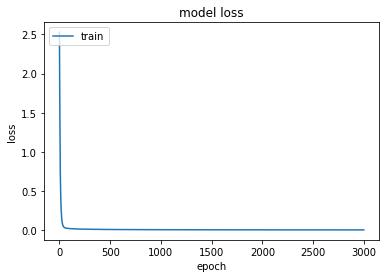

Procedure I
Statement 116:    1
Statement 13:    2
Statement 86:    3
Statement 105:    4
Statement 106:    5
Statement 107:    6
Statement 101:    7
Statement 82:    8
Statement 70:    9
Statement 28:   10
Statement 103:   11
Statement 24:   12
Statement 26:   13
Statement 68:   14
Statement 22:   15
Statement 99:   16
Statement 78:   17
Statement  9:   18
Statement 90:   19
Statement 31:   20
Statement 36:   21
Statement 38:   22
Statement 89:   23
Statement 102:   24
Statement 30:   25
Statement 81:   26
Statement 84:   27
Statement 10:   28
Statement 20:   29
Statement 48:   30
Statement 49:   31
Statement 50:   32
Statement 51:   33
Statement 52:   34
Statement 53:   35
Statement 54:   36
Statement 55:   37
Statement 57:   38
Statement 59:   39
Statement 61:   40
Statement 63:   41
Statement 65:   42
Statement 67:   43
Statement 14:   44
Statement 69:   45
Statement 18:   46
Statement 71:   47
Statement 73:   48
Statement 75:   49
Statement 77:   50
Statement 79:   51
Statement  2

In [5]:
if __name__ == '__main__':
    inputstream = '../input/encrpt-bug/encrypt_bug2_line14.csv'
    #n_statement = 90
    epochs = 3000
    lr = 0.03
    #m, result = get_train_data()
    m, result,n_statement = read_coverage(inputstream)
    trained_model = train_model(m,result, n_statement,epochs, lr)
    c_virtual = create_virtual_test(n_statement)
    r_virtual = trained_model.predict(c_virtual, batch_size=None, verbose=0, steps=None)
    procedure1(r_virtual)
    procedure2(r_virtual)